In [1]:
"""
Utility functions for context engineering notebooks.
"""

from rich.console import Console
from rich.panel import Panel
import json

console = Console()


def format_message_content(message):
    """Convert message content to displayable string"""
    if isinstance(message.content, str) and len(message.content.strip()) > 0:
        return message.content
    elif isinstance(message.content, str) and len(message.content) == 0:
        # Handle complex content like tool calls
        parts = []
        try:
        
            for item in message.tool_calls:

                if item.get('type') == 'text':
                    parts.append(item['text'])
                elif item.get('type') == 'tool_call':
                    parts.append(f"\n🔧 Tool Call: {item['name']}")
                    parts.append(f"   Args: {json.dumps(item['args'], indent=2)}")
            return "\n".join(parts)
        except:
            return str(message.content)
    else:
        return str(message.content)


def format_messages(messages):
    """Format and display a list of messages with Rich formatting"""
    for m in messages:
        msg_type = m.__class__.__name__.replace('Message', '')
        content = format_message_content(m)

        if msg_type == 'Human':
            console.print(Panel(content, title="🧑 Human", border_style="blue"))
        elif msg_type == 'Ai':
            console.print(Panel(content, title="🤖 Assistant", border_style="green"))
        elif msg_type == 'Tool':
            console.print(Panel(content, title="🔧 Tool Output", border_style="yellow"))
        else:
            console.print(Panel(content, title=f"📝 {msg_type}", border_style="white"))


def format_message(messages):
    """Alias for format_messages for backward compatibility"""
    return format_messages(messages)


def format_retriever_results(result, title="Retriever Tool Results"):
    """Format and display retriever tool results with proper text wrapping
    
    Args:
        result: List of documents from retriever tool or a string
        title: Title to display above the results
    """
    # Initialize console for rich formatting with width limit
    formatted_console = Console(width=100)
    
    formatted_console.print(f"[bold green]{title}:[/bold green]")
    
    # Handle case where result is a string
    if isinstance(result, str):
        formatted_console.print(f"\n[yellow]Content:[/yellow]")
        formatted_console.print(result, style="white")
        return
    
    # Handle case where result is a list of documents
    for i, doc in enumerate(result):
        formatted_console.print(f"\n[bold blue]Document {i+1}:[/bold blue]")
        
        # Check if doc has metadata attribute (Document object)
        if hasattr(doc, 'metadata'):
            formatted_console.print(f"[cyan]Source:[/cyan] {doc.metadata.get('source', 'Unknown')}")
            formatted_console.print(f"[yellow]Content:[/yellow]")
            formatted_console.print(doc.page_content, style="white")
        else:
            # Handle case where doc is just a string
            formatted_console.print(f"[yellow]Content:[/yellow]")
            formatted_console.print(str(doc), style="white")

In [2]:
from dotenv import load_dotenv

load_dotenv()
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

In [3]:
# Mathematical tool
def average(numbers: list[float]) -> float:
    """Calculate average of a list of numbers.
    
    Args:
        numbers: A list of numeric values to average.
        
    Returns:
        The average (mean) of the input list as a float.
    """
    return sum(numbers) / len(numbers)

# Mock data fetching tool
def fetch_population_data(query: str) -> str:
    """Return static population data for selected countries.
    
    This function simulates a web search and returns mock population 
    values for demonstration purposes.
    
    Args:
        query: A string containing the search request (unused in this mock).
        
    Returns:
        A string with formatted population data for selected countries in 2024.
    """
    return (
        "2024 Population Data:\n"
        "India: 1.44 billion\n"
        "Brazil: 214 million\n"
        "Japan: 125 million\n"
        "Canada: 39 million\n"
        "Germany: 84 million"
    )

In [4]:
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor

# Create math agent
math_agent = create_react_agent(
    model=llm,
    tools=[average],
    name="math_expert",
    prompt="""You are a math expert. You only solve numeric problems using the provided tools.
Rules:
- Use only tools for all calculations
- Do not guess or calculate in your head
- Do not fetch data or perform research"""
)
# Create research agent
research_agent = create_react_agent(
    model=llm,
    tools=[fetch_population_data],
    name="research_expert",
    prompt="""You are a research expert. You only retrieve and present factual data using the tool.
Rules:
- Use only the search tool to collect data
- Do not calculate or analyze numbers
- Present clean, structured facts"""
)

C:\Users\User\AppData\Local\Temp\ipykernel_10124\2110173481.py:6: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  math_agent = create_react_agent(
C:\Users\User\AppData\Local\Temp\ipykernel_10124\2110173481.py:17: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent = create_react_agent(


In [5]:
supervisor_prompt = """You manage two agents: a research expert and a math expert.
Your job is to:
- Identify the type of task
- Send research tasks to the research expert
- Send numeric analysis tasks to the math expert
- Coordinate between them if both are needed
Do not perform any task yourself. Always delegate.
"""
supervisor = create_supervisor(
    agents=[research_agent, math_agent],
    model=llm,
    prompt=supervisor_prompt
)

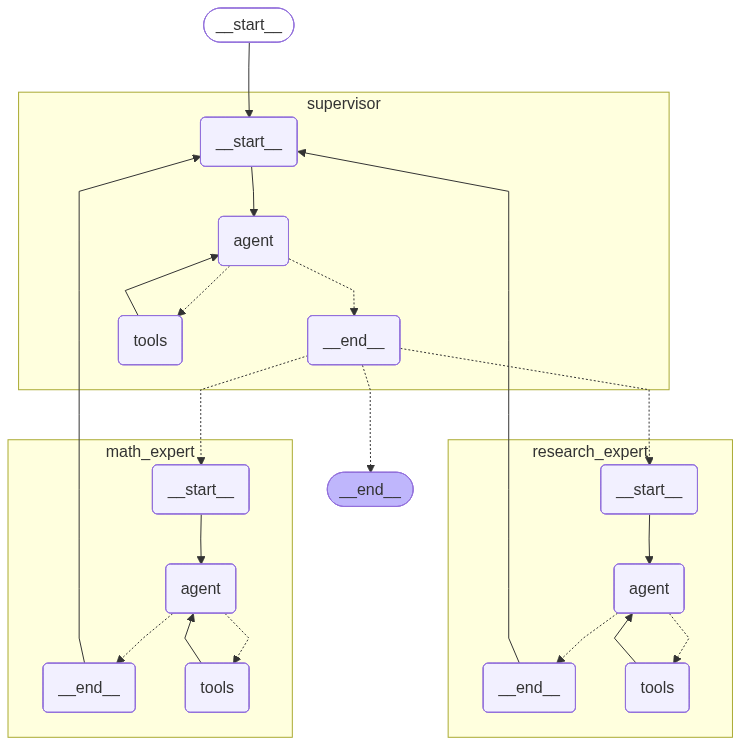

In [6]:
from IPython.display import Image, display

# Compile the supervisor workflow
app = supervisor.compile()
# Display the agent graph
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [7]:
# from utils import format_messages

query = "What is the average population of India, Brazil, Japan, Canada, and Germany in 2024?"
result = app.invoke({
    "messages": [{"role": "user", "content": query}]
})
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is the average population of India, Brazil, Japan, Canada, and Germany in 2024?                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I need to find the populations of India, Brazil, Japan, Canada, and Germany in 2024 and then calculate the      │
│ average. I will start by asking the research expert to find the populations.                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Successfully transferred to research_expert                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here is the population data for 2024:                                                                           │
│ *   India: 1.44 billion                                                                                         │
│ *   Brazil: 214 million                                                                                         │
│ *   Japan: 125 million                                                                                          │
│ *   Canada: 39 million                                                                                          │
│ *   Germany: 84 million                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Transferring back to supervisor                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Successfully transferred back to supervisor                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I have the population data from the research expert. Now I need to calculate the average population.            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Successfully transferred to math_expert                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The average population of India, Brazil, Japan, Canada, and Germany in 2024 is 380,400,000.                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Transferring back to supervisor                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Successfully transferred back to supervisor                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The average population of India, Brazil, Japan, Canada, and Germany in 2024 is 380.4 million.                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯